### Create AI - Image Semantic Segmentation Model

The project aims to enhance the accuracy of palm oil plantation segmentation by integrating the U-Net architecture with transfer learning from ResNet-34. U-Net’s symmetric structure and skip connections are adept at capturing spatial hierarchies, while ResNet-34’s pre-trained layers on vast datasets offer robust feature extraction capabilities. By combining these models, the project seeks to create a powerful semantic segmentation tool that can precisely delineate palm oil plantation areas from varied satellite imagery, contributing to more informed and sustainable agricultural practices. This approach not only promises improvements in segmentation precision but also expedites the training process, leveraging the strengths of both architectures for superior performance. 🌴🛰️

#### 1. Let's import the Dependencies

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use("ggplot")
%matplotlib inline
import gc

from tqdm.notebook import trange, tqdm

from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K

  
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *

import random 

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

2024-04-05 14:29:37.371762: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-05 14:29:37.564270: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-05 14:29:38.020707: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/mjanuadi/anaconda3/envs/image-dl/lib/:/lib:/home/mjanuadi/anaconda3/envs/image-dl/lib/:/lib

In [2]:
#Check Tensorflow Version
import tensorflow as tf
print(tf.__version__)

2.11.1


In [3]:
w, h = 128,128
border = 5 

In [4]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-04-05 14:29:46.116370: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-05 14:29:46.129948: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-05 14:29:46.129992: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


Import the dataset and Checking the number of image and mask

In [6]:
import glob
train_x = sorted(glob.glob(r'/home/mjanuadi/Unet_Resnet/data_train/images/*.png'))
train_y = sorted(glob.glob(r'/home/mjanuadi/Unet_Resnet/data_train/labels/*.png'))

print(len(train_x), len(train_y))


369 369


#### 2. Prepares image and mask data for deep learning tasks

The image will be converted into numpy array format

In [7]:
h, w = 256, 256

X = np.zeros((len(train_x), h, w, 3), dtype=np.float32)
y = np.zeros((len(train_y), h, w, 1), dtype=np.float32)

In [8]:
for n, (img, mimg) in tqdm(enumerate(zip(train_x, train_y))):
  # print(n, img, mimg)
  # Load images
  img = load_img(img)
  x_img = img_to_array(img)
  x_img = resize(x_img, (h, w, 3), mode = 'constant', preserve_range = True)
  # # Load masks
  mask = img_to_array(load_img(mimg, color_mode = "grayscale"))
  mask = resize(mask, (h, w, 1), mode = 'constant', preserve_range = True)
  # # Save images
  X[n] = x_img/255
  y[n] = mask

0it [00:00, ?it/s]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
gc.collect()

(332, 256, 256, 3) (332, 256, 256, 1) (37, 256, 256, 3) (37, 256, 256, 1)


68

In [74]:
X_train

array([[[[0.10980392, 0.2       , 0.12941177],
         [0.1254902 , 0.21960784, 0.14117648],
         [0.11764706, 0.22745098, 0.12941177],
         ...,
         [0.11764706, 0.19215687, 0.13333334],
         [0.10588235, 0.19215687, 0.14117648],
         [0.10980392, 0.18039216, 0.1254902 ]],

        [[0.11764706, 0.21176471, 0.11372549],
         [0.12941177, 0.21960784, 0.11372549],
         [0.11372549, 0.23921569, 0.12156863],
         ...,
         [0.11372549, 0.1882353 , 0.12941177],
         [0.11372549, 0.1882353 , 0.13333334],
         [0.10980392, 0.18431373, 0.12941177]],

        [[0.11372549, 0.20392157, 0.11764706],
         [0.13333334, 0.25490198, 0.13333334],
         [0.12941177, 0.25882354, 0.13333334],
         ...,
         [0.10980392, 0.18431373, 0.13333334],
         [0.11372549, 0.1882353 , 0.12941177],
         [0.11764706, 0.19215687, 0.1254902 ]],

        ...,

        [[0.12941177, 0.19215687, 0.12156863],
         [0.12941177, 0.2       , 0.12941177]

#### 4. Visualize Image and Mask

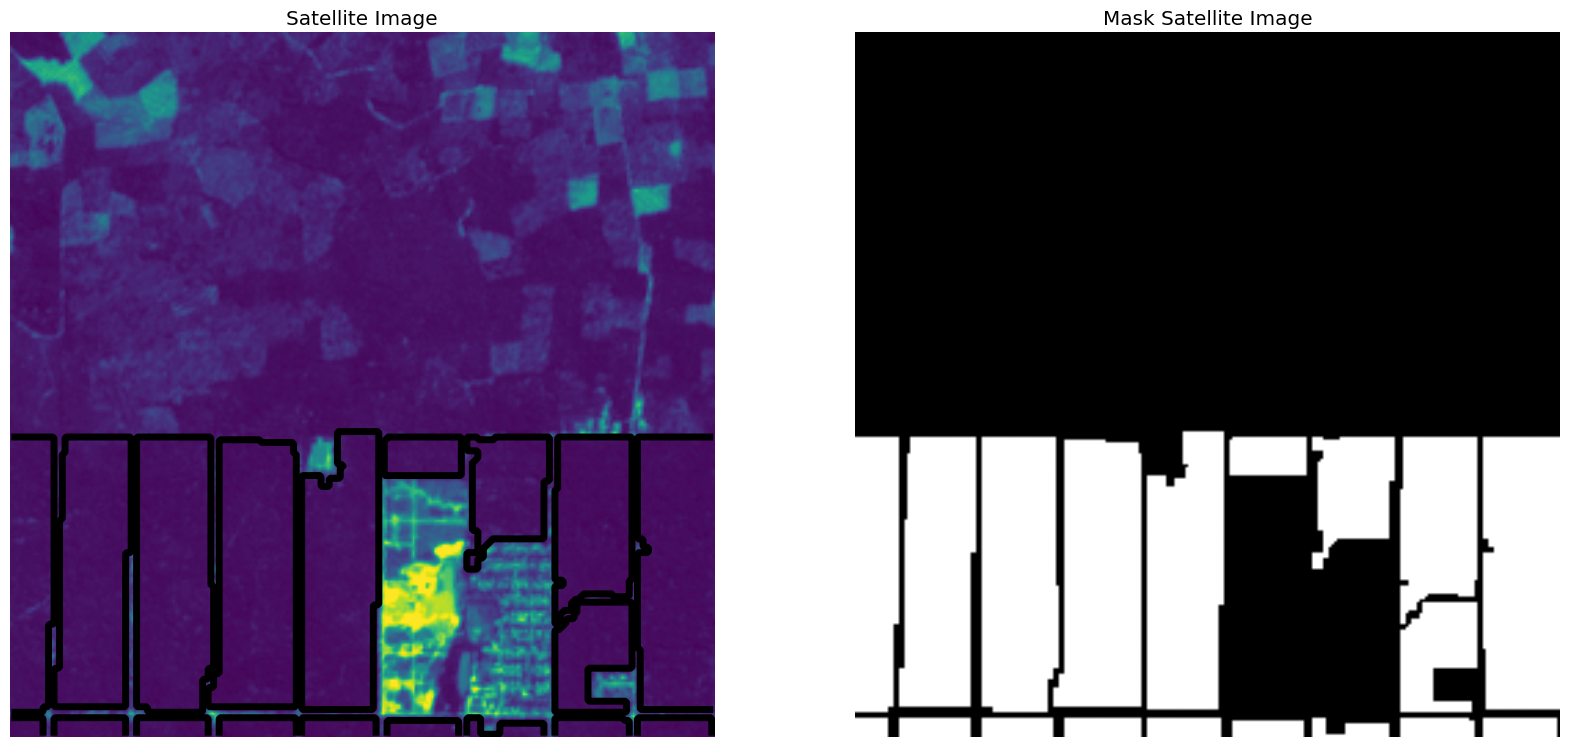

In [10]:
# Visualize any randome image along with the mask
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Satellite Image')
ax1.set_axis_off()
ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask Satellite Image')
ax2.set_axis_off()

#### 5. Create Unet Model for Palm Oil Detection
First let's create the Unet architecure

In [11]:
x_in = Input(shape=(256, 256, 3))

'''Encoder'''
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_in)
x_temp = Dropout(0.25)(x_temp)
x_skip1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip1)
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip2)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip3 = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip3)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)

'''Decoder'''
x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip3])
x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip2])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip1])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)

'''Use 1 by 1 Convolution to get desired output bands'''
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_out = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x_temp)
# use sigmoid activation here because output values are either 0 or 1

model = Model(inputs=x_in, outputs=x_out)

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 32  0           ['conv2d[0][0]']                 
                                )                                                             

2024-04-05 14:30:29.425181: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-05 14:30:29.426829: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-05 14:30:29.426906: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-05 14:30:29.426925: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0

 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['dropout[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 128, 32  0           ['conv2d_1[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 128, 128, 32  9248        ['max_pooling2d[0][0]']          
                                )                                                                 
                                                                                                  
 dropout_1 (Dropout)            (None, 128, 128, 32  0           ['conv2d_2[0][0]']               
          

Train the model based on the Unet architecture we've had created

In [12]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=10, verbose=1)

Epoch 1/50


2024-04-05 14:30:36.308617: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-05 14:30:37.518125: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-04-05 14:30:39.032382: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-05 14:30:42.344335: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-05 14:30:42.367824: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1db74f30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-05 14:30:42.367863: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): N

34/34 [==============================] - ETA: 0s - loss: 0.2264 - accuracy: 0.6667

2024-04-05 14:30:56.272257: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.86GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-05 14:30:56.272346: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.86GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


34/34 [==============================] - 22s 316ms/step - loss: 0.2264 - accuracy: 0.6667 - val_loss: 0.2462 - val_accuracy: 0.5565
Epoch 2/50
34/34 [==============================] - 7s 201ms/step - loss: 0.2074 - accuracy: 0.6756 - val_loss: 0.2227 - val_accuracy: 0.5565
Epoch 3/50
34/34 [==============================] - 6s 172ms/step - loss: 0.1936 - accuracy: 0.6756 - val_loss: 0.2125 - val_accuracy: 0.5565
Epoch 4/50
34/34 [==============================] - 6s 165ms/step - loss: 0.1831 - accuracy: 0.6756 - val_loss: 0.2064 - val_accuracy: 0.5565
Epoch 5/50
34/34 [==============================] - 6s 165ms/step - loss: 0.1830 - accuracy: 0.6756 - val_loss: 0.2048 - val_accuracy: 0.5565
Epoch 6/50
34/34 [==============================] - 6s 165ms/step - loss: 0.1851 - accuracy: 0.6756 - val_loss: 0.2063 - val_accuracy: 0.5565
Epoch 7/50
34/34 [==============================] - 6s 165ms/step - loss: 0.1787 - accuracy: 0.6756 - val_loss: 0.2039 - val_accuracy: 0.5565
Epoch 8/50
34/34

Let's see the loss training chart

In [13]:
df_result = pd.DataFrame(history.history)
df_result.sort_values('accuracy', ascending=True, inplace = True)
df_result

,loss,accuracy,val_loss,val_accuracy
0,0.226362,0.666685,0.246186,0.556496
1,0.207448,0.675632,0.222679,0.556496
2,0.193648,0.675632,0.212468,0.556496
3,0.183098,0.675632,0.206375,0.556496
4,0.183035,0.675632,0.204841,0.556496
5,0.185138,0.675632,0.206288,0.556496
6,0.178723,0.675633,0.203898,0.556496
8,0.177787,0.676193,0.200861,0.696692
7,0.183075,0.684098,0.219022,0.556521
9,0.167641,0.737668,0.162603,0.758025


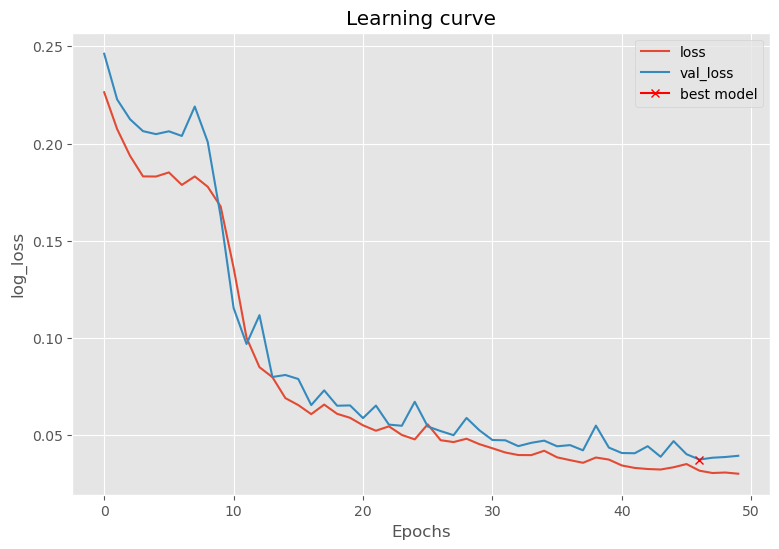

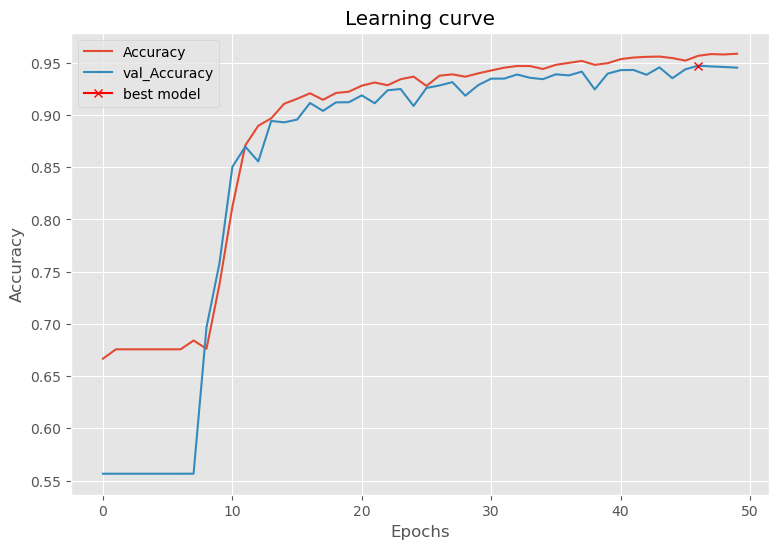

In [14]:
plt.figure(figsize = (9,6))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize = (9,6))
plt.title("Learning curve")
plt.plot(history.history["accuracy"], label="Accuracy")
plt.plot(history.history["val_accuracy"], label="val_Accuracy")
plt.plot(np.argmax(history.history["val_accuracy"]), np.max(history.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();
     

Let's inference and predict the Unet model into new dataset

2024-04-05 14:37:38.564806: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-05 14:37:38.564867: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-05 14:37:40.004078: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-05 14:37:40.004132: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

1/2 [==============>...............] - ETA: 3s

2024-04-05 14:37:42.093668: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.76GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-05 14:37:42.093717: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.76GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


2/2 [==============================] - 5s 1s/step
(37, 256, 256, 1)


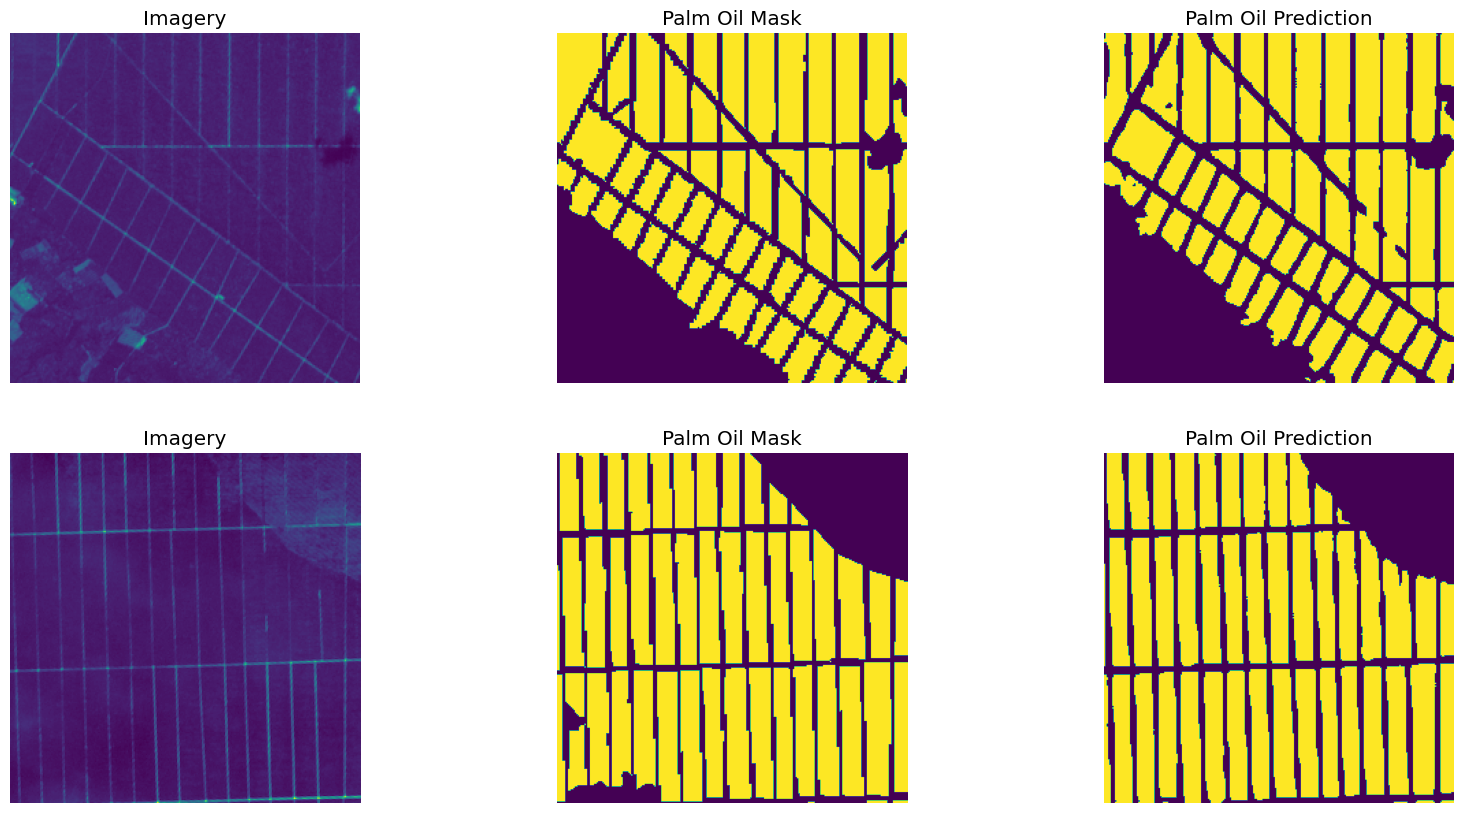

In [15]:
#Set the threshold
threshold = 0.5

# prediction of the output
pred_test = model.predict(X_test)
pred_test = (pred_test > threshold).astype(np.uint8)
print(pred_test.shape)

#let's comare random predicted and actial y values 
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

idx1 = 12
idx2 = 20

ax[0][0].imshow(X_test[idx1, :, :, 0])
ax[0][0].set_title("Imagery")
ax[0][0].set_axis_off()

ax[0][1].imshow(y_test[idx1, :, :, 0])
ax[0][1].set_title("Palm Oil Mask")
ax[0][1].set_axis_off()

ax[0][2].imshow(pred_test[idx1,:,:,0])
ax[0][2].set_title("Palm Oil Prediction")
ax[0][2].set_axis_off()


ax[1][0].imshow(X_test[idx2, :, :, 0])
ax[1][0].set_title("Imagery")
ax[1][0].set_axis_off()

ax[1][1].imshow(y_test[idx2, :, :, 0])
ax[1][1].set_title("Palm Oil Mask")
ax[1][1].set_axis_off()

ax[1][2].imshow(pred_test[idx2,:,:,0])
ax[1][2].set_title("Palm Oil Prediction")
ax[1][2].set_axis_off()

## 7. Transfer Learning Unet-Resnet34

U-Net with transfer learning using ResNet-34 is a powerful combination for image segmentation tasks. The U-Net architecture, known for its effectiveness in biomedical image segmentation, features a symmetric encoder-decoder structure with skip connections that help preserve spatial information. When combined with ResNet-34, which is pre-trained on large datasets like ImageNet, the model benefits from deep residual learning, allowing it to learn robust feature representations. This transfer learning approach helps in overcoming the challenge of training deep networks from scratch, especially when labeled data is scarce. By utilizing ResNet-34’s learned features, the U-Net model can achieve better generalization and improved segmentation results with fewer epochs of training

Create a Unet model using a transfer learning approach Resnet34

In [16]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [17]:
import tensorflow as tf
import segmentation_models as sm
import glob

import os
import numpy as np
from matplotlib import pyplot as plt
import keras 

from keras.utils import normalize
from keras.metrics import MeanIoU

In [18]:
n_classes = 1
activation = "sigmoid"

LR = 0.0001
optim = keras.optimizers.Adam(LR)

In [19]:
dice_loss  = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25]))
focal_loss = sm.losses.BinaryCELoss()
total_loss = dice_loss + focal_loss

In [20]:
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

X_train1 = preprocess_input1(X_train)
X_test1 = preprocess_input1(X_test)

In [21]:
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes = n_classes, activation=activation)

model1.compile(optim, total_loss, metrics=metrics)

In [22]:
print(model1.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

In [23]:
history1=model1.fit(X_train1, 
          y_train,
          batch_size=8, 
          epochs=50,
          verbose=1,
          validation_data=(X_test1, y_test))

Epoch 1/50
42/42 [==============================] - 21s 322ms/step - loss: 1.3434 - iou_score: 0.4975 - f1-score: 0.6460 - val_loss: 1.6715 - val_iou_score: 0.0054 - val_f1-score: 0.0107
Epoch 2/50
42/42 [==============================] - 7s 176ms/step - loss: 1.1540 - iou_score: 0.6731 - f1-score: 0.7984 - val_loss: 1.6961 - val_iou_score: 5.3120e-11 - val_f1-score: 5.3120e-11
Epoch 3/50
42/42 [==============================] - 6s 150ms/step - loss: 1.0942 - iou_score: 0.7242 - f1-score: 0.8367 - val_loss: 2.0378 - val_iou_score: 5.3120e-11 - val_f1-score: 5.3120e-11
Epoch 4/50
42/42 [==============================] - 6s 146ms/step - loss: 1.0424 - iou_score: 0.7686 - f1-score: 0.8675 - val_loss: 2.0680 - val_iou_score: 5.3120e-11 - val_f1-score: 5.3120e-11
Epoch 5/50
42/42 [==============================] - 6s 152ms/step - loss: 1.0181 - iou_score: 0.7846 - f1-score: 0.8770 - val_loss: 2.3821 - val_iou_score: 5.3120e-11 - val_f1-score: 5.3120e-11
Epoch 6/50
42/42 [===================

In [24]:
df_result = pd.DataFrame(history1.history)
df_result.sort_values('f1-score', ascending=True, inplace = True)
df_result

,loss,iou_score,f1-score,val_loss,val_iou_score,val_f1-score
0,1.343384,0.497473,0.646012,1.671461,5.396322e-03,1.073166e-02
1,1.153991,0.673125,0.798448,1.696147,5.311957e-11,5.311957e-11
2,1.094232,0.724181,0.836663,2.037774,5.311957e-11,5.311957e-11
3,1.042410,0.768583,0.867542,2.067954,5.311957e-11,5.311957e-11
4,1.018117,0.784579,0.877019,2.382137,5.311957e-11,5.311957e-11
5,0.990433,0.807354,0.891933,2.417887,5.311957e-11,5.311957e-11
8,0.960905,0.829049,0.904798,2.763625,5.311957e-11,5.311957e-11
6,0.952266,0.842593,0.914159,2.576776,5.311957e-11,5.311957e-11
9,0.934536,0.854632,0.921324,3.086033,5.311957e-11,5.311957e-11
7,0.936897,0.854877,0.921455,2.638107,5.311957e-11,5.311957e-11


In [106]:
model1.save('res34_backbone_50epochs.hdf5')

2/2 [==============================] - 3s 8ms/step
(37, 256, 256, 1)


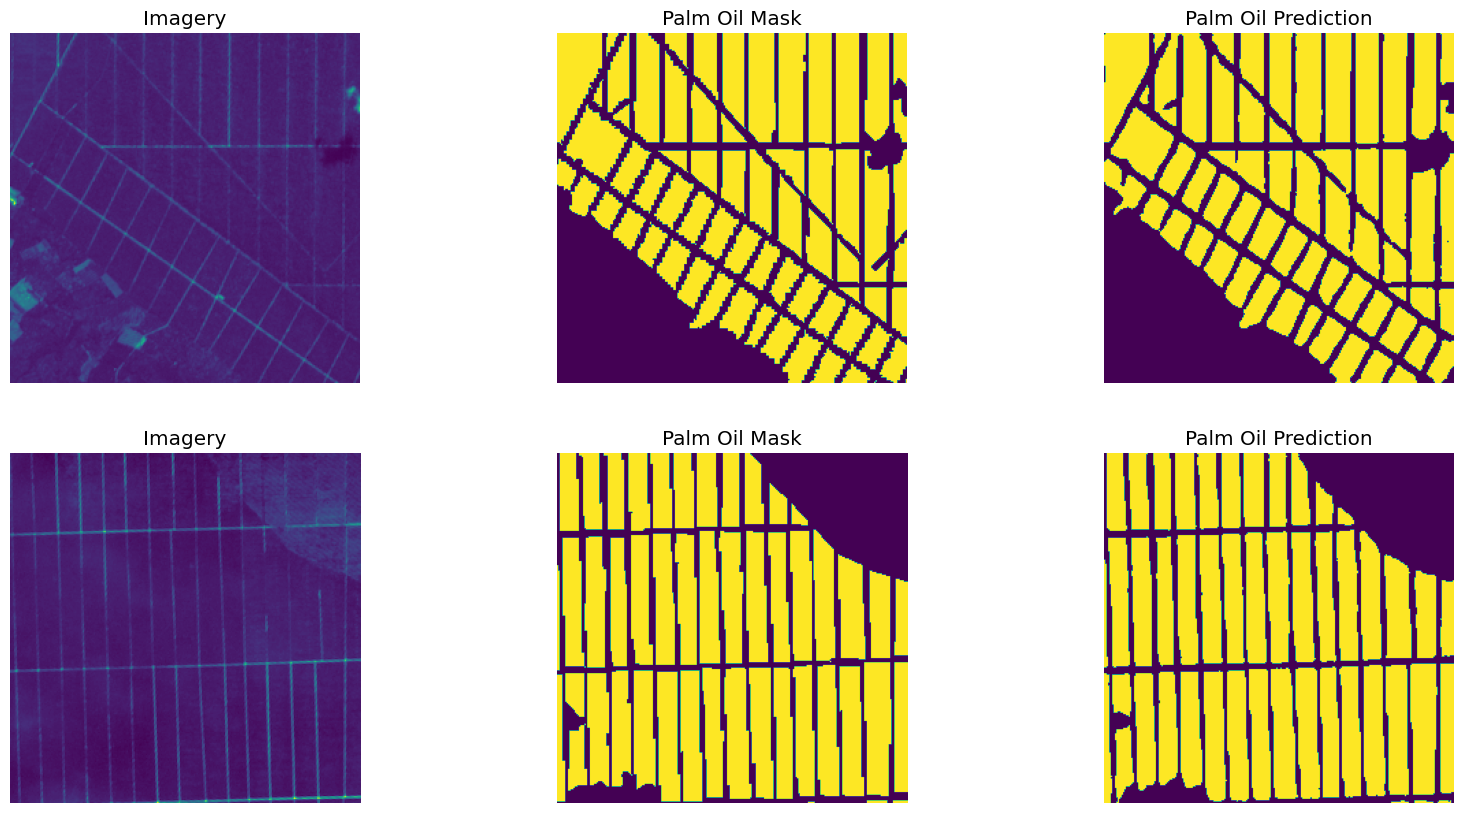

In [25]:
threshold = 0.5

# prediction of the output
pred_test = model1.predict(X_test)
pred_test = (pred_test > threshold).astype(np.uint8)
print(pred_test.shape)

#let's comare random predicted and actial y values 
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

idx1 = 12
idx2 = 20

ax[0][0].imshow(X_test[idx1, :, :, 0])
ax[0][0].set_title("Imagery")
ax[0][0].set_axis_off()

ax[0][1].imshow(y_test[idx1, :, :, 0])
ax[0][1].set_title("Palm Oil Mask")
ax[0][1].set_axis_off()

ax[0][2].imshow(pred_test[idx1,:,:,0])
ax[0][2].set_title("Palm Oil Prediction")
ax[0][2].set_axis_off()


ax[1][0].imshow(X_test[idx2, :, :, 0])
ax[1][0].set_title("Imagery")
ax[1][0].set_axis_off()

ax[1][1].imshow(y_test[idx2, :, :, 0])
ax[1][1].set_title("Palm Oil Mask")
ax[1][1].set_axis_off()

ax[1][2].imshow(pred_test[idx2,:,:,0])
ax[1][2].set_title("Palm Oil Prediction")
ax[1][2].set_axis_off()